# External evidence

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
with open("../data/eprints_repos.txt", "r") as f:
    eprints_repos = f.read().split("\n")

In [4]:
data_dir = "../data/analysis"

Merging info from all repos

In [17]:
dfs = []
for eprints_repo in eprints_repos:
    try:
        urls = pd.read_csv(os.path.join(data_dir, "cleaned_links", f"cleaned_urls_{eprints_repo}_2010-_github.com.csv"))
        metadata = pd.read_csv(os.path.join(data_dir, "eprints_pub", f"extracted_pdf_urls_{eprints_repo}_2010-.csv"))
    except FileNotFoundError:
        continue
    metadata["date"] = pd.to_datetime(metadata.date, errors="coerce")
    metadata["year"] = metadata.date.dt.year
    df = pd.merge(urls, metadata, how="right", on=["title", "author_for_reference", "pdf_url"])
    df["eprints_repo"] = eprints_repo
    dfs.append(df)
df = pd.concat(dfs)  # might contain duplicates

Data cleaning

In [5]:
def clean_dataset(df, remove_duplicate_pdf_mentions, remove_duplicate_pub_mentions):
    """Perform data cleaning steps.

    Args:
        df (pd.DataFrame): dataset
        remove_duplicate_pdf_mentions (bool): if True, drop duplicate links in one PDF
        remove_duplicate_pub_mentions (bool): if True, drop duplicate links ocurring on the same page in different PDF links (across repos), and also all duplicates of publications with no links

    Returns:
        pd.DataFrame: cleaned dataset
    """
    df = df[df.year <= datetime.now().year]
    df = df.astype({"year": int})
    # drop duplicate links in one PDF
    if remove_duplicate_pdf_mentions:
        df = df.drop_duplicates(subset=["title", "author_for_reference", "pdf_url", "github_user_cleaned_url"])
    # drop duplicate links ocurring on the same page in different PDF links (across repos), and also all duplicates of publications with no github links
    if remove_duplicate_pub_mentions:
        df = df.drop_duplicates(subset=["title", "author_for_reference", "page_no", "github_user_cleaned_url"])
    return df


In [6]:
df = clean_dataset(df, True, True)

Total number of GitHub URLs in ePrints per year:

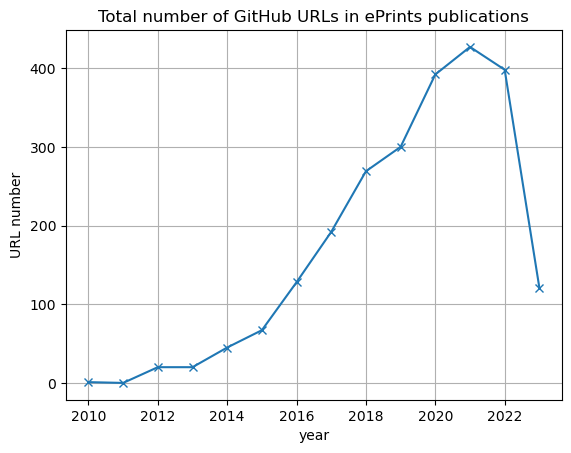

In [8]:
urls_per_year = df.groupby("year")['github_user_cleaned_url'].count()
urls_per_year.plot(
    xlabel="year",
    ylabel="URL number",
    title="Total number of GitHub URLs in ePrints publications",
    marker="x",
    grid=True
)
plt.savefig("../data/analysis/overall/github_in_eprints.png")

Average number of GitHub URLs in an ePrints publication:

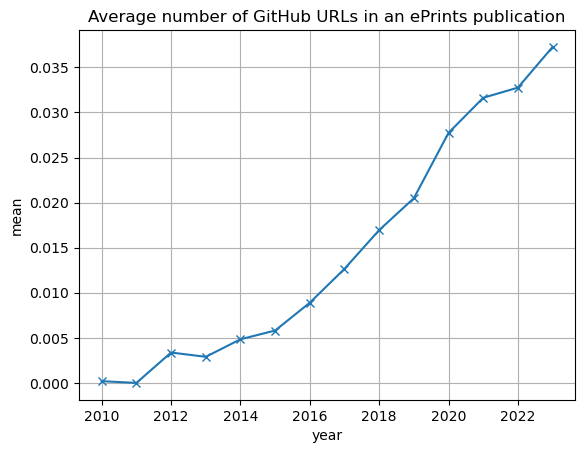

In [10]:
urls_per_publication = df.groupby(["year", "title", "author_for_reference", "pdf_url"])["github_user_cleaned_url"].count()
urls_per_publication.groupby("year").mean().plot(
    xlabel="year",
    ylabel="mean",
    title="Average number of GitHub URLs in an ePrints publication",
    marker="x",
    grid=True
)
plt.savefig("../data/analysis/overall/avg_github_in_eprints.png")

Number of publications in ePrints that have at least one GitHub URL:

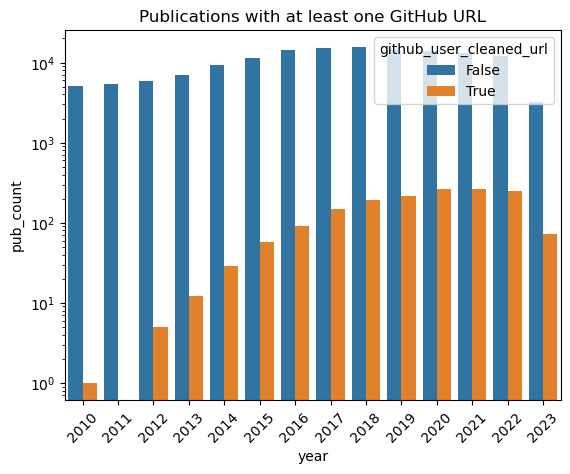

In [12]:
min_one_url = (urls_per_publication > 0).groupby("year").value_counts().rename("pub_count").reset_index()
ax = sns.barplot(
    data=min_one_url,
    x="year",
    y="pub_count",
    hue="github_user_cleaned_url",
)
ax.set(yscale="log")
ax.tick_params(axis='x', labelrotation=45)
plt.title("Publications with at least one GitHub URL")
plt.savefig("../data/analysis/overall/min_one_github_in_eprints.png")